In [1]:
import dask.dataframe as dd
import pandas as pd
!pip install fastparquet
from fastparquet import ParquetFile
pd.set_option('display.max_columns', None)

     |████████████████████████████████| 153kB 2.7MB/s 
     |████████████████████████████████| 61kB 4.6MB/s 
  Created wheel for fastparquet: filename=fastparquet-0.4.0-cp36-cp36m-linux_x86_64.whl size=251886 sha256=36bb3b90455428513f3c642a53740f2f55d1831e555719a6c1db25689f0024a6
  Stored in directory: /root/.cache/pip/wheels/2f/1d/6f/d10f8d2688469c279b71799a457a1fd8f35e5ba06e91b7d993
  Created wheel for thrift: filename=thrift-0.13.0-cp36-cp36m-linux_x86_64.whl size=345219 sha256=db0a8ffec87723b669fea5cd4576464eb06767c83251c623a1f71e0c42895aed
  Stored in directory: /root/.cache/pip/wheels/02/a2/46/689ccfcf40155c23edc7cdbd9de488611c8fdf49ff34b1706e
Successfully built fastparquet thrift


In [2]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 2.7MB/s 


In [0]:
import re
from scipy.spatial.distance import cosine
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

import logging

import matplotlib.pyplot as plt
% matplotlib inline

# Load the dataset


In [14]:
#Loading reviews data
reviews = dd.read_parquet('https://tally-ai-dspt3.s3.amazonaws.com/yelp-restaurants/reviews.parquet.gzip')
reviews.head()

,review_id,business_id,reviews_stars,date,text
index,,,,,
0,ipufYjKx5saLVuDR6f6o0w,S9RoY_Smsh0a2JPo90bkdg,5,2017-08-21 02:03:08,Was there with a girlfriend at lunch time toda...
1,VNOhF-xUYguSjA01yx5nwA,S9RoY_Smsh0a2JPo90bkdg,2,2017-08-20 17:46:40,I thought my meal was OK. I ordered an omelett...
2,PMXYXphbbkx2TM80AtIpQQ,S9RoY_Smsh0a2JPo90bkdg,2,2015-12-10 17:53:39,It's just a breakfast not too fancy. Weak coff...
3,7hxilsquX34WXHYc80qLkw,S9RoY_Smsh0a2JPo90bkdg,1,2017-09-02 18:54:37,"Shoule be zero stars! So, we have been here a ..."
4,Xnf39DsDWqiv1wulL2NK9g,S9RoY_Smsh0a2JPo90bkdg,5,2017-04-30 05:33:08,I LOVE this place!!! I'm so happy they opened ...


In [15]:
#Loading business data
business = dd.read_csv('https://tally-ai-dspt3.s3.amazonaws.com/yelp-restaurants/business.csv', blocksize=None)
business.head()

,Unnamed: 0,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,state,business_stars
0,8,404 E Green St,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...",pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",Champaign,"{'Monday': '11:30-14:30', 'Tuesday': '11:30-14...",1,40.110446,-88.233073,The Empanadas House,61820,5,IL,4.5
1,20,4508 E Independence Blvd,"{'RestaurantsGoodForGroups': 'True', 'OutdoorS...",CsLQLiRoafpJPJSkNX2h5Q,"Food, Restaurants, Grocery, Middle Eastern",Charlotte,NaN,0,35.194894,-80.767442,Middle East Deli,28205,5,NC,3.0
2,24,"15480 Bayview Avenue, unit D0110","{'RestaurantsTableService': 'False', 'Restaura...",eBEfgOPG7pvFhb2wcG9I7w,"Restaurants, Cheesesteaks, Poutineries",Aurora,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",1,44.010962,-79.448677,Philthy Phillys,L4G 7J1,4,ON,4.5
3,25,300 John Street,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...",lu7vtrp_bE9PnxWfA8g4Pg,"Japanese, Fast Food, Food Court, Restaurants",Thornhill,NaN,1,43.820492,-79.398466,Banzai Sushi,L3T 5W4,7,ON,4.5
4,30,13071 Yonge Street,"{'Ambience': ""{'touristy': False, 'hipster': F...",9sRGfSVEfLhN_km60YruTA,"Persian/Iranian, Turkish, Middle Eastern, Rest...",Richmond Hill,"{'Tuesday': '12:0-21:0', 'Wednesday': '12:0-21...",1,43.947011,-79.454862,Apadana Restaurant,L4E 1A5,3,ON,3.0


In [0]:
#Conver dd to pd dataframe
reviews = reviews.compute()

In [0]:
# Load pre-trained model tokenizer(vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [71]:
# locate the records containing "awesome", "excellent" and "great"
reviews_tmp = reviews[reviews['text'].str.contains("^(?=.*awesome)(?=.*excellent)(?=.*great).+",
                                   flags=re.IGNORECASE, regex=True)]
print(reviews_tmp.shape)
reviews_tmp

(6262, 5)


,review_id,business_id,reviews_stars,date,text
index,,,,,
592,J4CpLMrMz7ETqQU9_8kBeA,7sb2FYLS2sejZKxRYF9mtg,5,2016-12-15 02:33:31,Excellent! All you can eat and bogo beer?!? ...
1008,FxlfIn1oe5OVf-oBqvCZ5g,7sb2FYLS2sejZKxRYF9mtg,5,2016-11-05 21:51:16,awesome sushi every time. salmon lemon roll an...
1258,QHbj1cG_DlwZbIyB6xoBHw,7sb2FYLS2sejZKxRYF9mtg,4,2016-12-18 23:42:02,"Great atmosphere, good music and excellent men..."
1551,0rCuo-QSDvSAEfBYwuDswg,7sb2FYLS2sejZKxRYF9mtg,5,2018-03-23 06:34:08,I read the reviews and knew I wanted to try th...
3768,saSenPAM9VdpoFfrDhNhvA,gtg8Hld2EyJrFoB-272SIg,5,2014-02-25 19:25:10,My mom and I went here the other night for her...
...,...,...,...,...,...
13945,4iCmDMWrO7tSyDICRKEE_A,RwlumSqNBunw1a1LXccN8A,5,2016-09-28 23:45:20,"I went to Snooze for breakfast on Tuesday, Sep..."
14405,AyqIs3Ro27rpAuHtdRnILg,RwlumSqNBunw1a1LXccN8A,5,2018-07-04 04:26:58,Best breakfast place ever! Pancakes are awesom...
14587,I5Rv1cyBR35P2C95Nv-kHg,RwlumSqNBunw1a1LXccN8A,4,2018-07-25 14:34:13,EXCELLENT breakfast spot. The variety of the s...


In [27]:
reviews.dtypes

review_id                object
business_id              object
reviews_stars             int64
date             datetime64[ns]
text                     object
dtype: object

In [75]:
text = reviews_tmp['text'].values[6261]
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'great', 'sandwiches', 'at', 'an', 'affordable', 'prices', '(', 'under', '$', '10', ')', '.', 'comes', 'with', '2', 'sides', 'that', 'are', 'excellent', '.', 'the', 'staff', 'when', 'above', 'and', 'beyond', 'to', 'help', 'me', 'craft', 'a', 'sandwich', 'i', 'would', 'love', '.', 'they', 'were', 'awesome', '!', 'the', 'chef', 'in', 'the', 'back', 'actually', 'listened', 'to', 'what', 'i', 'wanted', 'and', 'gave', 'me', 'some', 'recommendations', ',', 'and', 'even', 'customized', 'my', 'order', 'to', 'my', 'liking', '.', 'it', 'was', 'clean', 'and', 'well', 'kept', '.', 'we', 'will', 'be', 'returning', 'here', 'for', 'sure', '.', '[SEP]']


In [76]:
# Map the token strings to their vocabulary indices.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indices.
for tup in zip(tokenized_text, indexed_tokens):
  print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
great         2,307
sandwiches   22,094
at            2,012
an            2,019
affordable   15,184
prices        7,597
(             1,006
under         2,104
$             1,002
10            2,184
)             1,007
.             1,012
comes         3,310
with          2,007
2             1,016
sides         3,903
that          2,008
are           2,024
excellent     6,581
.             1,012
the           1,996
staff         3,095
when          2,043
above         2,682
and           1,998
beyond        3,458
to            2,000
help          2,393
me            2,033
craft         7,477
a             1,037
sandwich     11,642
i             1,045
would         2,052
love          2,293
.             1,012
they          2,027
were          2,020
awesome      12,476
!               999
the           1,996
chef         10,026
in            1,999
the           1,996
back          2,067
actually      2,941
listened      7,791
to            2,000
what          2,054


In [77]:
# Mark each of the 15 tokens as belonging to sentence "1"
segments_ids = [1] * len(tokenized_text)
print(segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [0]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# Load BERT base model

In [79]:
# Load pre-trained model(weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

100%|██████████| 407873900/407873900 [00:35<00:00, 11374379.54B/s]


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

In [0]:
# Predict hidden states features for each layer
with torch.no_grad():
  encoded_layers, _ = model(tokens_tensor, segments_tensors)

In [81]:
print ("Number of layers:", len(encoded_layers))
layer_i = 0
print ("Number of batches:", len(encoded_layers[layer_i]))
batch_i = 0
print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
token_i = 0
print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

Number of layers: 12
Number of batches: 1
Number of tokens: 83
Number of hidden units: 768


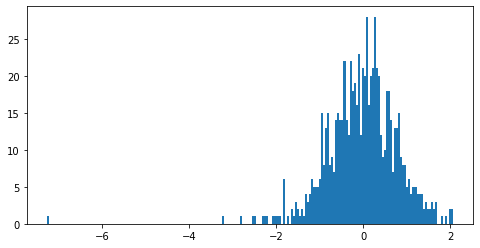

In [82]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = encoded_layers[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(8,4))
plt.hist(vec, bins=200)
plt.show()

In [83]:
# `encoded_layers` is a Python list.
print('Type of encoded_layers: ', type(encoded_layers))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', encoded_layers[0].size())

Type of encoded_layers:  <class 'list'>
Tensor shape for each layer:  torch.Size([1, 83, 768])


# Token Vectors